In [101]:
#download required dependencies 
!pip install geopandas
!pip install netCDF4
!pip install minisom

In [102]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#load in functions required and dependencies to use them
#%run all_functions.ipynb
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import geopandas as gpd
import pickle
from netCDF4 import Dataset
import minisom
from sklearn.cluster import KMeans

In [0]:
#define functions that we'll use

def nse(y_obs, y_model):

  """
  NSE = nse(y_obs, y_model)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x1) where N is the number of observations in time
  """

  y_model = y_model.reshape((-1,1))
  y_obs = y_obs.reshape((-1,1))
  nse = 1 - np.sum((y_model - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2)
  return nse

def nse_rolling(y_obs, y_model, window, stride = 1):

  """
  NSE_rolling = nse_rolling(y_obs, y_model, window, stride)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
  window --> this is the length of time over which to compute NSE, which will roll accross the total time period
  stride --> default stride = 1; length of step to take when rolling (i.e. stride = 365 computes yearly NSE with no overlap)
  """

  NSE_rolling = []

  y_model = y_model.reshape((-1,1))
  y_obs = y_obs.reshape((-1,1))

  startInds = range(0, len(y_model) - window, stride)
  for startInd in startInds:
    y_model_window = y_model[startInd:startInd+window] 
    y_obs_window = y_obs[startInd:startInd+window]
    NSE = nse(y_obs_window, y_model_window)
    NSE_rolling.append(NSE)

  return NSE_rolling

def plot_AB(prov='AB'):

    """
    plot borders of alberta
    
    example:
    import geopandas as gpd
    import matplotlib.pyplot as plt
    plot_AB()
    plt.show()
    """
    
    provIndex=0
    provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/PROVINCE.SHP'
    provshapes = gpd.read_file(provshapes_filename)
    provPoly = provshapes['geometry'][provIndex]
    lonBorder,latBorder = provPoly.exterior.coords.xy 

    plt.plot(lonBorder,latBorder,'k')

def rmse(target,prediction):
  return(np.sqrt(((target - prediction)**2).sum()/len(target)))

def rmse_group(*args):
  rmse_group = []
  for arg in args:
    for other_arg in args:
      rmse_group.append(rmse(arg,other_arg))

  rmse_group = np.mean(rmse_group)

  return rmse_group

In [0]:
#load data

colabDataPath = '/content/drive/My Drive/Colab Notebooks/T_P_F_pca_lstm/'

pickle_in = open(colabDataPath + 'flowDict.pickle','rb')
flowDict = pickle.load(pickle_in)

pickle_in = open(colabDataPath + 'tempDict.pickle','rb')
tempDict = pickle.load(pickle_in)

pickle_in = open(colabDataPath + 'precDict.pickle','rb')
precDict = pickle.load(pickle_in)

pickle_in = open(colabDataPath + 'relHDict.pickle','rb')
relHDict = pickle.load(pickle_in)

pickle_in = open(colabDataPath + 'ssrdDict.pickle','rb')
ssrdDict = pickle.load(pickle_in)

In [0]:
#unpack data

stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']

F = flowDict['all_flowwindow_norm_NF'] #normalized discharge with nans filled (NF)
T = tempDict['T']
P = precDict['P']
H = relHDict['H']
S = ssrdDict['S']

x_lat = np.empty((len(eraLat),len(eraLon)))
kk = 0
for lat in eraLat:
    x_lat[kk,:] = lat
    kk+=1
    
x_lon = np.empty((len(eraLat),len(eraLon)))
kk = 0
for lon in eraLon:
    x_lon[:,kk] = lon
    kk+=1

In [0]:
#set nan values to mean values of field (ie: out of province values

meanT = np.nanmean(T)
meanP = np.nanmean(P)
meanH = np.nanmean(H)
meanS = np.nanmean(S)
meanLat = np.nanmean(x_lat)
meanLon = np.nanmean(x_lon)

Tall = np.copy(T)
Tall[np.where(np.isnan(Tall))] = np.nanmean(T)
T = Tall

Pall = np.copy(P)
Pall[np.where(np.isnan(Pall))] = np.nanmean(P)
P = Pall

Hall = np.copy(H)
Hall[np.where(np.isnan(Hall))] = np.nanmean(H)
H = Hall

Sall = np.copy(S)
Sall[np.where(np.isnan(Sall))] = np.nanmean(S)
S = Sall

x_lat_all = np.copy(x_lat)
x_lat_all[np.where(np.isnan(x_lat_all))] = np.nanmean(x_lat)
x_lat = x_lat_all

x_lon_all = np.copy(x_lon)
x_lon_all[np.where(np.isnan(x_lon_all))] = np.nanmean(x_lon)
x_lon = x_lon_all

In [0]:
#select just stations with glaciers?

customStations = 1

if customStations:

  stationInds = np.array([18,19,34,35,59,60,61,64,69,102,103,104,106,107,127,150,163,176]) - 1
  stationInds = np.array([1,2,3,9,13,26,27,41,49,62,68,76,77,78,86,120,130,131,132,134,167,18,19,34,35,59,60,61,64,69,102,103,104,106,107,127,150,163,176])-1 #these are the stations with a record > 90 years, mean flow > 1 m^3/s
  stationInds = np.array([2,13,27,41,62,78,86,120,131,132,134,167,19,35,59,60,61,64,102,103,106,107,127,150,163,176]) - 1 #these are the stations with a record > 90 years, mean flow > 1 m^3/s, fewest nans
  stationInds = np.array([2,13,27,62,86,120,132,134,167,19,35,59,60,64,102,103,106,107,127,150,163,176]) - 1 #these are the stations with a record > 90 years, mean flow > 1 m^3/s, fewest nans, and don't have a min flow close to zero
  F = np.asarray(F)
  F = np.transpose(np.squeeze(F[stationInds]))

else:

  stationInds = np.arange(0,194,1)
  F = np.asarray(np.transpose(np.squeeze(F[indStartFlow:])))

In [0]:
#make data have same time range
startYear = max(int(np.min(eraYears)),int(np.min(flowYears)))

indStartERA = min(np.argwhere(eraYears==startYear))[0]
indStartFlow = min(np.argwhere(flowYears==startYear))[0]

#F = np.asarray(np.transpose(np.squeeze(F[indStartFlow:])))
T = np.asarray(T[indStartERA:])
P = np.asarray(P[indStartERA:])
H = np.asarray(H[indStartERA:])
S = np.asarray(S[indStartERA:])

#just alberta
T = T[:,:15,29:]
P = P[:,:15,29:]
H = H[:,:15,28:]
S = S[:,:15,28:]
x_lat = x_lat[:15,29:] * np.ones(np.shape(T))
x_lon = x_lon[:15,29:] * np.ones(np.shape(T))

flowDays = flowDays[indStartFlow:]
flowMonths = flowMonths[indStartFlow:]
flowYears = flowYears[indStartFlow:]

eraDays = eraDays[indStartERA:]
eraMonths = eraMonths[indStartERA:]
eraYears = eraYears[indStartERA:]

In [110]:
print(np.shape(F),np.shape(T),np.shape(P),np.shape(H),np.shape(S), np.shape(x_lat), np.shape(x_lon))

(8766, 22) (8766, 15, 14) (8766, 15, 14) (8766, 15, 14) (8766, 15, 14) (8766, 15, 14) (8766, 15, 14)


In [0]:
#prep data: standardize

#indices of testing/training
trainStartYear = 1987
trainFinYear = 2005
testStartYear = 2006
testFinYear = 2010

trainInds = np.squeeze(np.argwhere((flowYears>=trainStartYear) & (flowYears<=trainFinYear)))
testInds = np.squeeze(np.argwhere((flowYears>=testStartYear) & (flowYears<=testFinYear)))

#standardize variables individually (normalize wrt training period), then save as 32-bit rather than 64-bit for space
Tmean_train = np.mean([T[trainInds[ii]] for ii in range(len(trainInds))])
Tstd_train = np.std([T[trainInds[ii]] for ii in range(len(trainInds))])
Tnorm = (T - Tmean_train)/Tstd_train
Tnorm = np.single(Tnorm)

Pmean_train = np.mean([P[trainInds[ii]] for ii in range(len(trainInds))])
Pstd_train = np.std([P[trainInds[ii]] for ii in range(len(trainInds))])
Pnorm = (P - Pmean_train)/Pstd_train
Pnorm = np.single(Pnorm)

Hmean_train = np.mean([H[trainInds[ii]] for ii in range(len(trainInds))])
Hstd_train = np.std([H[trainInds[ii]] for ii in range(len(trainInds))])
Hnorm = (H - Hmean_train)/Hstd_train
Hnorm = np.single(Hnorm)

Smean_train = np.mean([S[trainInds[ii]] for ii in range(len(trainInds))])
Sstd_train = np.std([S[trainInds[ii]] for ii in range(len(trainInds))])
Snorm = (S - Smean_train)/Sstd_train
Snorm = np.single(Snorm)

x_lat_mean_train = np.mean([x_lat[trainInds[ii]] for ii in range(len(trainInds))])
x_lat_std_train = np.std([x_lat[trainInds[ii]] for ii in range(len(trainInds))])
x_lat_norm = (x_lat - x_lat_mean_train)/x_lat_std_train
x_lat_norm = np.single(x_lat_norm)

x_lon_mean_train = np.mean([x_lon[trainInds[ii]] for ii in range(len(trainInds))])
x_lon_std_train = np.std([x_lon[trainInds[ii]] for ii in range(len(trainInds))])
x_lon_norm = (x_lon - x_lon_mean_train)/x_lon_std_train
x_lon_norm = np.single(x_lon_norm)

##Fmean_train = np.nanmean([F[ii][trainInds[366:]] for ii in range(len(F))])
##Fstd_train = np.nanstd([F[ii][trainInds[366:]] for ii in range(len(F))])
#Fmean_train = np.mean(F[trainInds[366:],:])
#Fstd_train = np.std(F[trainInds[366:],:])
#Fnorm = (F - Fmean_train)/Fstd_train
#Fnorm = np.single(Fnorm)

In [0]:
#normalize flow

Fnorm = np.empty_like(F)
for station in range(np.shape(F)[1]):
    #F[:,station] = (F[:,station] - np.mean(F[:,station]))/np.std(F[:,station])
    minF = np.min(F[:,station])
    maxF = 2 * np.std(F[:,station])
    Fnorm[:,station] = (F[:,station] - minF) / (maxF - minF)
    
#for inds in np.argwhere(F>10):
#  F[inds[0],inds[1]] = 10

In [0]:
#construct train and test predictor/target tensors

#target data
y_train = np.squeeze([Fnorm[365:trainInds[-1]+1,ii] for ii in range(np.shape(F)[1])]).T
y_test = np.squeeze([Fnorm[testInds,ii] for ii in range(np.shape(F)[1])]).T
y = np.empty((len(y_train[:,0])+len(y_test[:,0]),np.shape(F)[1])).T
y[:,:len(y_train[:,0])] = y_train.T
y[:,len(y_train[:,0]):] = y_test.T
y = y.T

#first, make (n_time x n_lon x n_lat x n_vars) tensor 
#x_intermediate = np.zeros((8766,17,43,2))
x_intermediate = np.empty((8766,15,14,6),dtype='single')
x_intermediate[:,:,:,0] = Tnorm
x_intermediate[:,:,:,1] = Pnorm
x_intermediate[:,:,:,2] = Hnorm
x_intermediate[:,:,:,3] = Snorm
x_intermediate[:,:,:,4] = x_lat_norm
x_intermediate[:,:,:,5] = x_lon_norm
x_train_intermediate = x_intermediate[trainInds]
x_test_intermediate = x_intermediate[testInds]

In [0]:
#now, convert x_intermediate into (n_time x 365 x n_lon x n_lat x n_vars) tensor
x = np.empty((8766-365,365,15,14,6),dtype=np.float16)
x_train = np.empty((len(trainInds)-365,365,15,14,6),dtype=np.float16)
x_test = np.empty((len(testInds),365,15,14,6),dtype=np.float16)

In [0]:
for ii in range(1000):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(1000,2000):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(2000,3000):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(3000,4000):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(4000,len(trainInds)-365):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(1000):
    x_test[ii] = x_intermediate[ii+len(trainInds)-365:ii+len(trainInds)]

In [19]:
for ii in range(1000,2000):
    x_test[ii] = x_intermediate[ii+len(trainInds)-365:ii+len(trainInds)]

IndexError: ignored

In [0]:
for ii in range(1000,len(testInds)):
    x_test[ii] = x_intermediate[ii+len(trainInds)-365:ii+len(trainInds)]

In [0]:
saveTrainVars=0
if saveTrainVars:
    np.savez("T_P_H_train_1987_2000_era_interim", x_train)
    #np.savez_compressed("T_P_train_1987_2000_era_interim_compressed", x_train)
    
saveTestVars=0
if saveTestVars:
    np.savez("T_P_H_test_1987_2000_era_interim", x_test)
    #np.savez_compressed("T_P_test_1987_2000_era_interim_compressed", x_test)

In [0]:
##shift predictions to be one day earlier
#x = x[2:]
#x_test = x_test[2:]
#x_train = x_train[2:]

#y = y[:-2]
#y_test = y_test[:-2]
#y_train = y_train[:-2]

In [124]:
import tensorflow.keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#CNN model
print('Building model...')
model = Sequential()

model.add(TimeDistributed(
    Conv2D(filters = 8, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
    input_shape=(365,15,14,6)))

model.add(TimeDistributed(
    Conv2D(filters = 8, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
    input_shape=(365,15,14,6)))

model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

model.add(TimeDistributed(
    Conv2D(filters = 16, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
    ))

model.add(TimeDistributed(
    Conv2D(filters = 16, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
    ))

model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

#model.add(TimeDistributed(
#    Conv2D(filters = 32, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
#    ))

#model.add(TimeDistributed(
#    Conv2D(filters = 32, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
#    ))

#model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))
model.add(TimeDistributed(Flatten()))

#LSTM model with time-distributed CNN as input
#model.add(LSTM(units = 40, activation='tanh', recurrent_activation='hard_sigmoid', 
#               use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', 
#               bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, 
#               recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
#               kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, implementation=1, 
#               return_sequences=True, return_state=False))
#model.add(LSTM(units = 40, activation='tanh', recurrent_activation='hard_sigmoid', 
#               use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', 
#               bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, 
#               recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
#               kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, implementation=1, 
#               return_sequences=False, return_state=False))
#model.add(Dense(194, activation = 'relu'))

model.add(LSTM(20, return_sequences=True))
model.add(Dropout(rate=0.1))
model.add(LSTM(20, return_sequences=True))
model.add(Dropout(rate=0.1))
model.add(Flatten())
model.add(Dense(np.shape(F)[1], activation = 'linear'))

#compile
print('Compiling model...')
model.compile(loss=tensorflow.keras.losses.MSE,
              optimizer=tensorflow.keras.optimizers.Adam(lr=0.005))

es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience = 3)

model.summary()

Building model...
Compiling model...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, 365, 15, 14, 8)    440       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 365, 15, 14, 8)    584       
_________________________________________________________________
time_distributed_23 (TimeDis (None, 365, 7, 7, 8)      0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 365, 7, 7, 16)     528       
_________________________________________________________________
time_distributed_25 (TimeDis (None, 365, 7, 7, 16)     1040      
_________________________________________________________________
time_distributed_26 (TimeDis (None, 365, 3, 3, 16)     0         
_________________________________________________________________
time_distributed_

In [126]:
#fit
batch_size = 256
epochs = 10
history = model.fit(
            x_train, y_train,
            validation_split = 0.2,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1, 
            callbacks = [es],
          )

Train on 5260 samples, validate on 1315 samples
Epoch 1/10
5260/5260 [==============================] - 21s 4ms/sample - loss: 0.0646 - val_loss: 0.0806
Epoch 2/10
5260/5260 [==============================] - 21s 4ms/sample - loss: 0.0635 - val_loss: 0.0793
Epoch 3/10
5260/5260 [==============================] - 21s 4ms/sample - loss: 0.0625 - val_loss: 0.0785
Epoch 4/10
5260/5260 [==============================] - 21s 4ms/sample - loss: 0.0610 - val_loss: 0.0769
Epoch 5/10
5260/5260 [==============================] - 21s 4ms/sample - loss: 0.0597 - val_loss: 0.0768
Epoch 6/10
5260/5260 [==============================] - 21s 4ms/sample - loss: 0.0586 - val_loss: 0.0758
Epoch 7/10
5260/5260 [==============================] - 21s 4ms/sample - loss: 0.0577 - val_loss: 0.0753
Epoch 8/10
5260/5260 [==============================] - 21s 4ms/sample - loss: 0.0567 - val_loss: 0.0763
Epoch 9/10
5260/5260 [==============================] - 21s 4ms/sample - loss: 0.0556 - val_loss: 0.0761
Epoch 1

In [82]:
#fit
batch_size = 64
epochs = 10
history = model.fit(
            x_train, y_train,
            validation_split = 0.2,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1, 
            callbacks = [es],
          )

Train on 5260 samples, validate on 1315 samples
Epoch 1/10
5260/5260 [==============================] - 10s 2ms/sample - loss: 0.0691 - val_loss: 0.0944
Epoch 2/10
5260/5260 [==============================] - 10s 2ms/sample - loss: 0.0628 - val_loss: 0.0928
Epoch 3/10
5260/5260 [==============================] - 10s 2ms/sample - loss: 0.0545 - val_loss: 0.0999
Epoch 4/10
5260/5260 [==============================] - 10s 2ms/sample - loss: 0.0488 - val_loss: 0.0995
Epoch 5/10
5260/5260 [==============================] - 10s 2ms/sample - loss: 0.0433 - val_loss: 0.1127
Epoch 00005: early stopping


In [242]:
np.shape(x_test)

(1826, 365, 15, 14, 6)

In [127]:
print('Calculating predicted training values...')
y_train_predicted = model.predict(x_train, batch_size = 256, verbose = 1)

print('Calculating predicted testing values...')
y_test_predicted = model.predict(x_test, batch_size = 256, verbose = 1)

print('Calculating all predicted values...')
#y_predicted = model.predict(x, batch_size = 256, verbose = 1)
y_predicted = np.vstack((y_train_predicted,y_test_predicted))

Calculating predicted training values...
6575/6575 [==============================] - 5s 764us/sample
Calculating predicted testing values...
1826/1826 [==============================] - 1s 683us/sample
Calculating all predicted values...


In [0]:
del x_train, x_test #this did a chunk

In [0]:
del model #this did nothing

In [0]:
del history #this did a bit

In [0]:
del x #this did nothing

In [0]:
del x_intermediate, x_test_intermediate, x_train_intermediate 

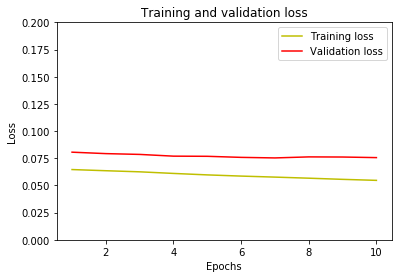

In [128]:
#visualize training loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.ylim((0,0.2))
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
np.shape(y_test_predicted), len(testInds), np.shape(x_test), np.shape(y_test)

NameError: ignored

IndexError: ignored

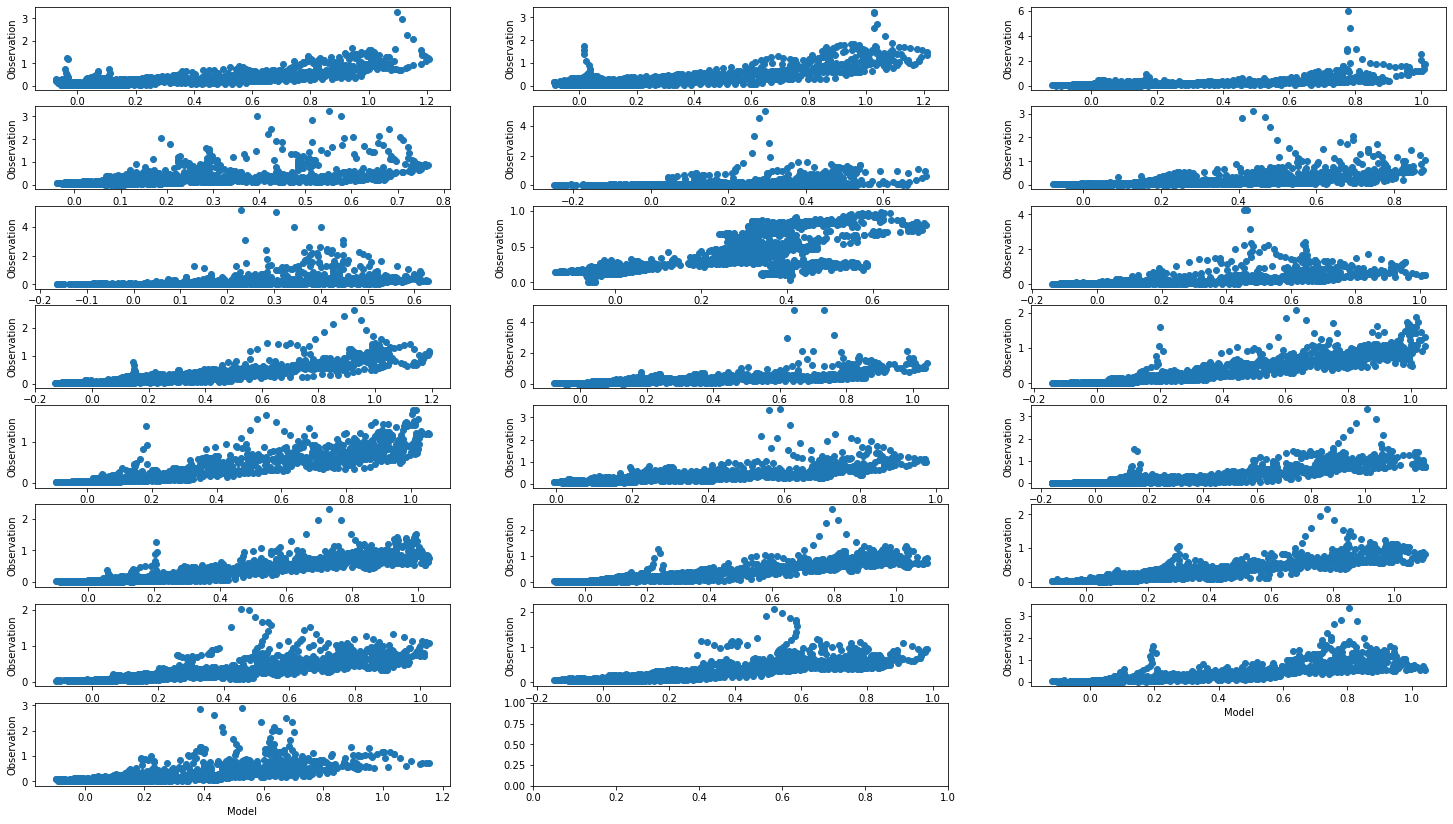

In [129]:
n_target = 40
plt.figure(figsize=(np.sqrt(n_target)*4,np.sqrt(n_target)*4))

for pred in range(n_target):

    plt.subplot(int(np.ceil(n_target/3)),3,pred+1)
    plt.scatter(y_test_predicted[:,pred],y_test[:,pred])
    plt.xlabel('Model')
    plt.ylabel('Observation')
    #plt.ylim((-0.1,1))

plt.tight_layout()
plt.show()

In [0]:
#check r2 at each station

from sklearn.metrics import r2_score

r2 = np.empty(np.shape(F)[1])
for kk in range(np.shape(F)[1]):
  r2[kk] = r2_score(y_test[:,kk],y_test_predicted[:,kk])

# Investigate Performance in Space and Time

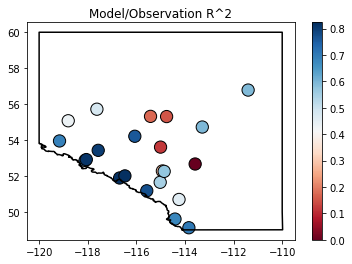

In [132]:
#visualize

plt.scatter(stationLon[stationInds],stationLat[stationInds],c=r2,cmap='RdBu',vmin = 0, s = 150, edgecolors = 'k')
plot_AB()
plt.title('Model/Observation R^2')
plt.colorbar()
plt.show()

In [0]:
dataPath = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/'

#what are the streamflow predictions at each station?

num_stations = len(stationInds)

NSE_station = []
NSE_rolling_station = []

for station in range(num_stations):
  
  NSE = nse(y[:,station], y_predicted[:,station])
  NSE_station.append(NSE)

  NSE_rolling = nse_rolling(y[:,station], y_predicted[:,station], window = 366, stride = 365)
  NSE_rolling = np.asarray(NSE_rolling)
  thresh = 0
  indices = NSE_rolling < thresh
  NSE_rolling[indices] = 0
  NSE_rolling_station.append(NSE_rolling)

NSE_rolling_station = np.asarray(NSE_rolling_station).T
#NSE_rolling_station[np.argwhere(NSE_rolling_station<0)] = 0

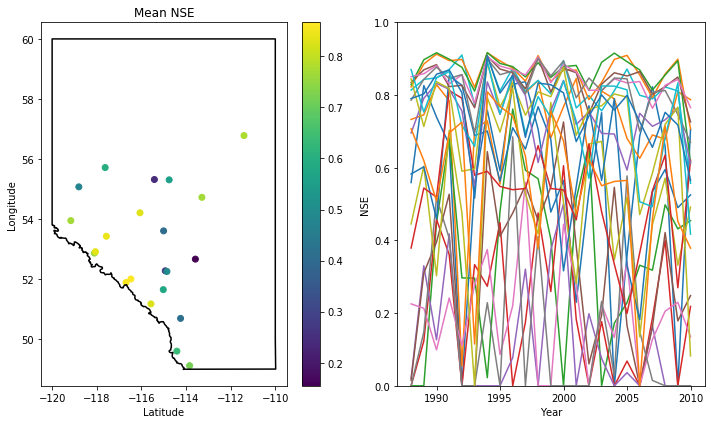

In [134]:
#visualize performance

saveIt = 0

plt.figure(figsize = (10,6))

plt.subplot(1,2,1)
#inds = stationsWithGlaciers[range(num_stations)]
#inds = [val for val in range(num_stations)]
plt.scatter(stationLon[stationInds], stationLat[stationInds], c = NSE_station)
plot_AB()
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Mean NSE')
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(range(1988,2011),NSE_rolling_station)
plt.xlabel('Year')
plt.ylabel('NSE')
plt.ylim((0,1))

plt.tight_layout()

if saveIt == 1:
  plt.savefig('meanNSE_and_series.png')

plt.show()

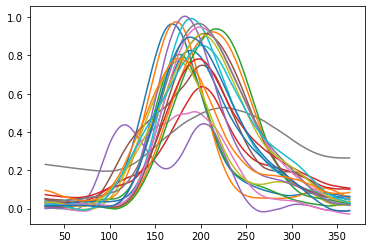

In [135]:
#compute smoothed seasonal over test period
#plan: find leap years, remove last day of SF from leap years, reshape SF at each station into matrix, find average

windowYears = flowDict['windowYears']
trainYears = windowYears[trainInds]
testYears = windowYears[testInds]
windowYears = windowYears[365:]
trainYears = trainYears[365:]

yearsForSOM = windowYears
yForSOM = np.copy(y_predicted)
totalYears = yearsForSOM[-1] - yearsForSOM[0]

##the first value in y_test is the second day in testInds
#y_new = np.empty((np.shape(y_test)[0],np.shape(y_test)[1]+1),dtype='single')
#y_new[:,1:] = y_test
#y_new[:,0] = y_new[:,1]

lastDayOfYear = np.argwhere(yearsForSOM[1:] - yearsForSOM[:-1] == 1) + 1
lastDayOfLeapYear = lastDayOfYear[np.argwhere(lastDayOfYear[1:]-lastDayOfYear[:-1] == 366)[:,0]+1]
lastDayOfLeapYear = np.vstack((lastDayOfLeapYear,366))
y_new1 = np.copy(yForSOM)
y_new2 = np.delete(y_new1,lastDayOfLeapYear,axis=0)

y_test_seasonal = np.empty((365,np.shape(F)[1]),dtype='single')
y_test_seasonal_smooth = np.empty_like(y_test_seasonal)

for streamGauge in range(num_stations):
    
    dummy = np.reshape(y_new2[:,streamGauge],(totalYears+1,365))
    y_test_seasonal[:,streamGauge] = np.mean(dummy,axis=0)
    
    x = pd.Series(y_test_seasonal[:,streamGauge])      
    y_test_seasonal_smooth[:,streamGauge] = x.rolling(30).mean()

for ii in range(np.shape(F)[1]):
    plt.plot(y_test_seasonal_smooth[:,ii])

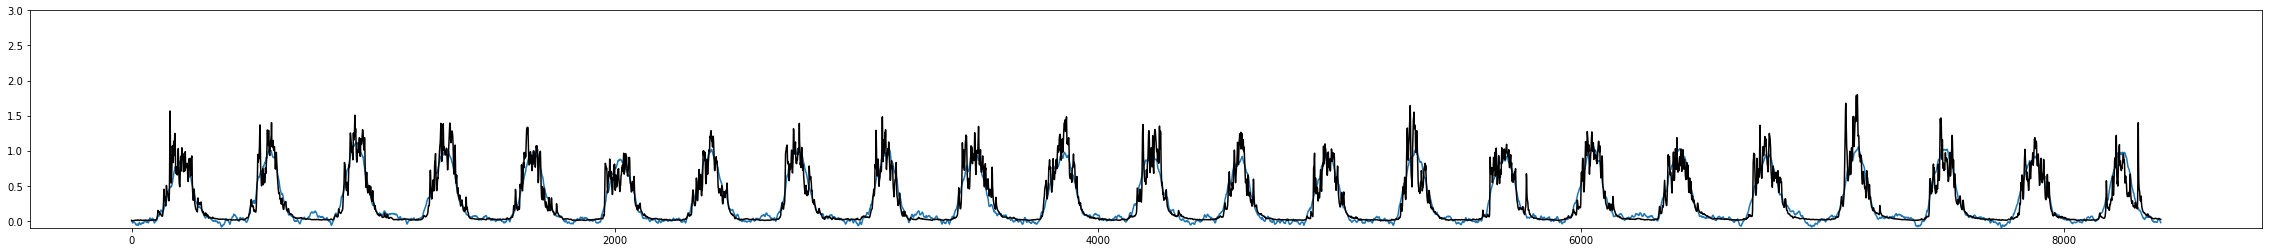

In [136]:
plt.figure(figsize = (40,4))
plt.plot(y_predicted[:,12])
plt.plot(y[:,12],'k')
plt.ylim((-0.1,3))
plt.show()

/usr/local/lib/python3.6/dist-packages/minisom.py:304: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


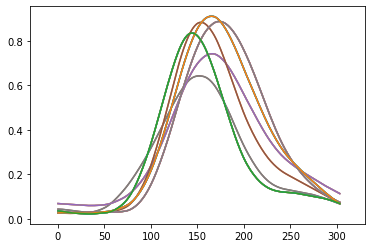

In [137]:
plt.plot(y_test_seasonal_smooth[0])

from minisom import MiniSom   
data = y_test_seasonal_smooth[31:-30].T
som = MiniSom(3, 2, 304, sigma=1, learning_rate=0.5) # initialization of 6x6 SOM
som.pca_weights_init(data)
som.train_random(data, 500) # trains the SOM with 100 iterations

qnt = som.quantization(data)

for ii in range(np.shape(F)[1]):
    plt.plot(qnt[ii,:])
    plt.xlim((-30,330))

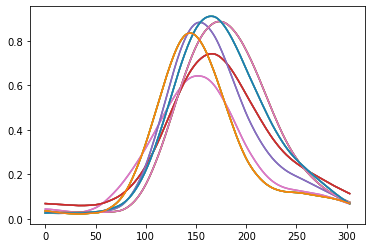

In [138]:
plt.plot(qnt.T)
plt.show()

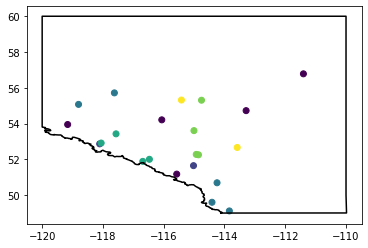

In [139]:
w = []
bmus = []
bmus_ref = [[1,4],[2,5],[3,6]]
for ii in range(np.shape(F)[1]):
    w.append(som.winner(data[ii,:]))
    bmus.append(bmus_ref[w[ii][0]][w[ii][1]])

plot_AB()
plt.scatter(stationLon[stationInds],stationLat[stationInds],c=bmus)

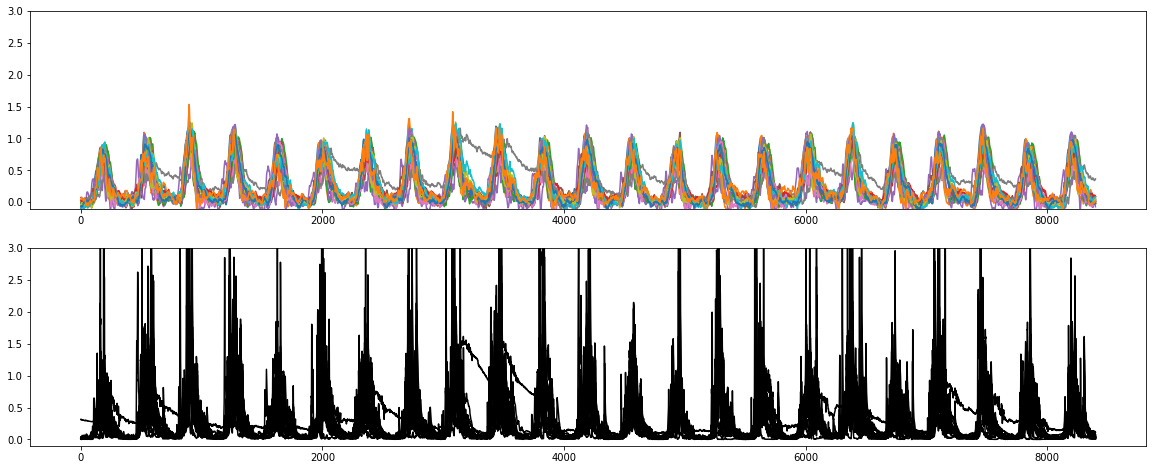

In [140]:
plt.figure(figsize = (20,8))
plt.subplot(211)
plt.plot(y_predicted)
plt.ylim((-0.1,3))
plt.subplot(212)
plt.plot(y,'k')
plt.ylim((-0.1,3))
plt.show()

In [0]:
#cluster NSE time series

data = NSE_rolling_station.T

n_clusters = 5
kmeans = KMeans(n_clusters = n_clusters).fit(data)
labels = kmeans.labels_

#find mean pattern of each cluster
cluster_pattern = np.empty((n_clusters,np.shape(data)[1]))
for cluster_num in range(n_clusters):
    inds = np.argwhere(labels==cluster_num)
    cluster_pattern[cluster_num,:] = np.mean(data[inds,:],axis=0)
    
cluster_obs = np.empty((np.shape(data)))
for ind in range(len(data)):
    cluster_obs[ind] = cluster_pattern[labels[ind]]


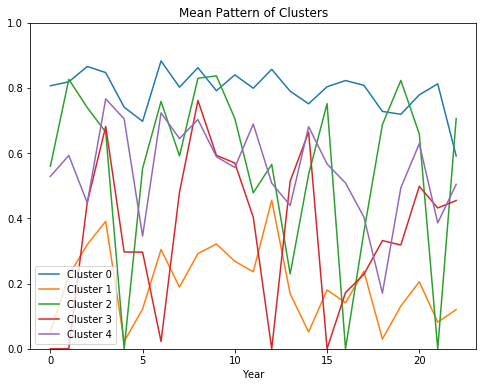

In [142]:
#visualize clusters

plt.figure(figsize = (8,6))

plt.plot(cluster_pattern.T)
plt.xlabel('Year')
plt.title('Mean Pattern of Clusters')
plt.legend(['Cluster ' + str(ii) for ii in range(n_clusters)])
plt.ylim((0,1))
plt.show()

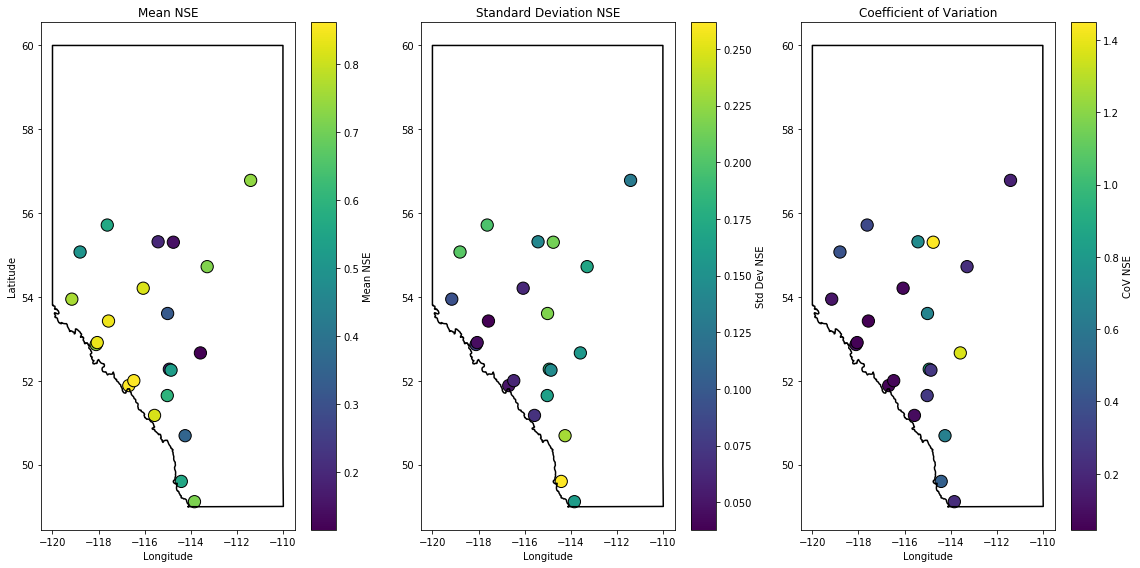

In [143]:
#plot mean NSE and variability of NSE

#inds = stationsWithGlaciers[range(num_stations)]

NSE_mean_stations = np.mean(NSE_rolling_station,axis=0)
NSE_std_stations = np.std(NSE_rolling_station,axis=0)
NSE_cov_stations = NSE_std_stations / NSE_mean_stations

plt.figure(figsize = (16,8))

plt.subplot(1,3,1)
plt.scatter(stationLon[stationInds], stationLat[stationInds], c = NSE_mean_stations, s = 150, edgecolors = 'k')
plot_AB()
#plt.scatter(stationLon[inds[-4:]],stationLat[inds[-4:]], marker = 's')
cbar = plt.colorbar()
cbar.set_label('Mean NSE')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mean NSE')

plt.subplot(1,3,2)
plt.scatter(stationLon[stationInds], stationLat[stationInds], c = NSE_std_stations, s = 150, edgecolors = 'k')
plot_AB()
cbar = plt.colorbar()
cbar.set_label('Std Dev NSE')
plt.xlabel('Longitude')
plt.title('Standard Deviation NSE')

plt.subplot(1,3,3)
plt.scatter(stationLon[stationInds], stationLat[stationInds], c = NSE_cov_stations, s = 150, edgecolors = 'k')
plot_AB()
cbar = plt.colorbar()
cbar.set_label('CoV NSE')
plt.xlabel('Longitude')
plt.title('Coefficient of Variation')

plt.tight_layout()
plt.show()

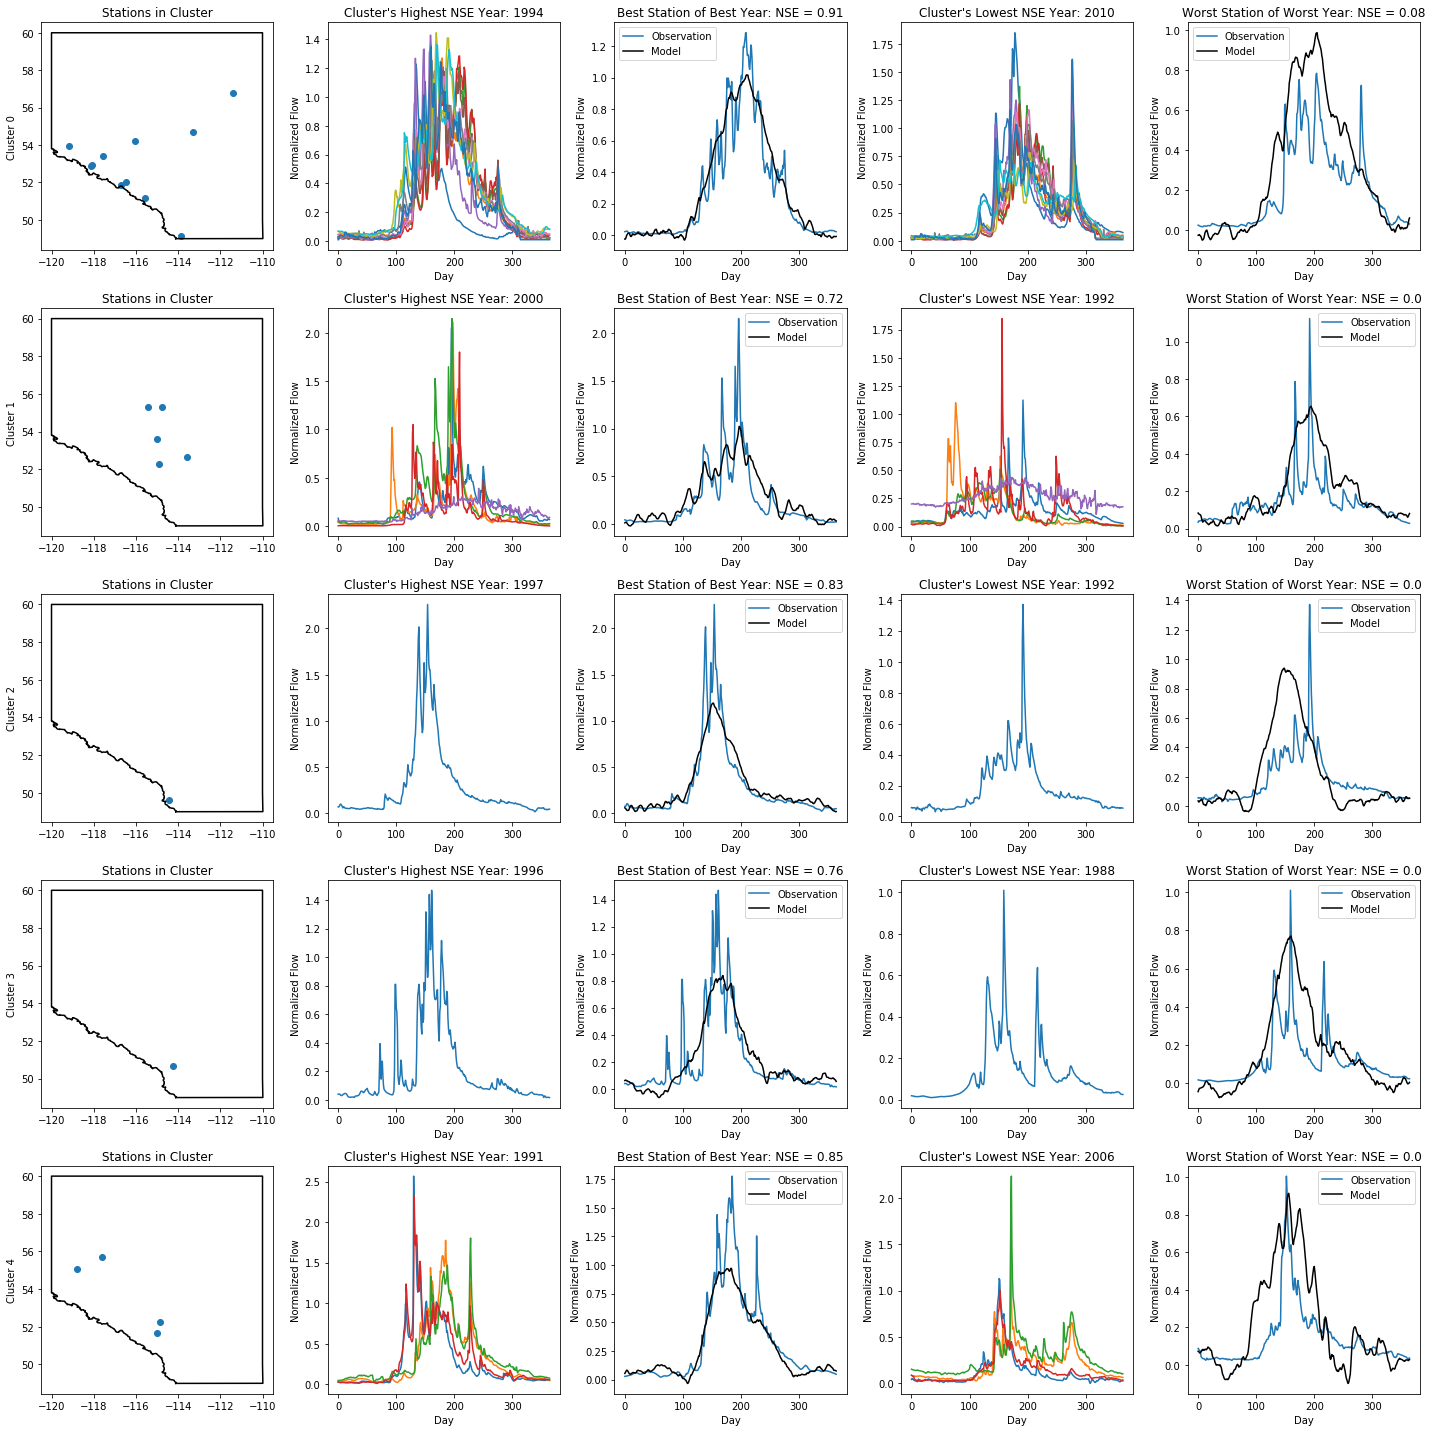

In [144]:
#what are the characteristics of the years with the highest and lowest NSE?

#make plot: rows are clusters, columns are 'best performing years' and 'worst performing years'

years = range(1988,2011)
n_cols = 5
plt.figure(figsize = (n_cols*4, n_clusters*4))

for cluster in range(n_clusters): #for each cluster

  #identify indices of rivers in this cluster
  stations_in_cluster = np.squeeze(stationInds[np.argwhere(labels==cluster)])
  if np.size(stations_in_cluster)==1: #if only one station, expand dimensions so array has a length of 1 so we can index the array
    stations_in_cluster = np.expand_dims(stations_in_cluster, axis = 0)
  stations_in_cluster_inds = np.reshape([np.argwhere(stationInds == stations_in_cluster[kk]) for kk in range(len(stations_in_cluster))],(-1,))

  #identify best and worst years/stations
  best_year = np.argmax(cluster_pattern[cluster])
  worst_year = np.argmin(cluster_pattern[cluster])
  NSE_stations_in_cluster = NSE_rolling_station[:,stations_in_cluster_inds]
  NSE_stations_best_year = NSE_stations_in_cluster[best_year,:]
  NSE_stations_worst_year = NSE_stations_in_cluster[worst_year,:]
  best_station_ind = stations_in_cluster_inds[np.argmax(NSE_stations_best_year)]
  worst_station_ind = stations_in_cluster_inds[np.argmin(NSE_stations_worst_year)]

  #plot stations in this cluster
  plt.subplot(n_clusters, n_cols, cluster*n_cols + 1)
  plot_AB()
  plt.scatter(stationLon[stations_in_cluster], stationLat[stations_in_cluster])
  plt.ylabel('Cluster ' + str(cluster))
  plt.title('Stations in Cluster')

  #plot all cluster members' flow during this best year
  plt.subplot(n_clusters, n_cols, cluster*n_cols + 2)
  for kk in stations_in_cluster_inds: #for each stream gauge in cluster
    start_ind = best_year*365
    final_ind = start_ind + 365
    plt.plot(y[start_ind:final_ind,kk])
    plt.xlabel('Day')
    plt.ylabel('Normalized Flow')
    plt.title('Cluster\'s Highest NSE Year: ' + str(years[best_year]))

  #plot the best performing cluster member in this best year, and it's modelled output
  plt.subplot(n_clusters, n_cols, cluster*n_cols + 3)
  start_ind = best_year*365
  final_ind = start_ind + 365
  plt.plot(y[start_ind:final_ind,best_station_ind], label = 'Observation')
  plt.plot(y_predicted[start_ind:final_ind,best_station_ind], color = 'k', label = 'Model')
  plt.xlabel('Day')
  plt.ylabel('Normalized Flow')
  plt.title('Best Station of Best Year: NSE = ' + str(NSE_rolling_station[best_year, best_station_ind])[:4])
  plt.legend()

  #plot all cluster members' flow during this worst year
  plt.subplot(n_clusters, n_cols, cluster*n_cols + 4)
  for kk in stations_in_cluster_inds: #for each stream gauge in cluster
    start_ind = worst_year*365
    final_ind = start_ind + 365
    plt.plot(y[start_ind:final_ind,kk])
    plt.xlabel('Day')
    plt.ylabel('Normalized Flow')
    plt.title('Cluster\'s Lowest NSE Year: ' + str(years[worst_year]))

  #plot the worst performing cluster member in this worst year, and it's modelled output
  plt.subplot(n_clusters, n_cols, cluster*n_cols + 5)
  start_ind = worst_year*365
  final_ind = start_ind + 365
  plt.plot(y[start_ind:final_ind,worst_station_ind], label = 'Observation')
  plt.plot(y_predicted[start_ind:final_ind, worst_station_ind], color = 'k', label = 'Model')
  plt.xlabel('Day')
  plt.ylabel('Normalized Flow')
  plt.title('Worst Station of Worst Year: NSE = ' + str(NSE_rolling_station[worst_year, worst_station_ind])[:4])
  plt.legend()

  plt.tight_layout()

plt.show()

